# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [26]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

In [27]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [28]:
def show_average_images(train_loader, test_loader, dataset, labels):
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


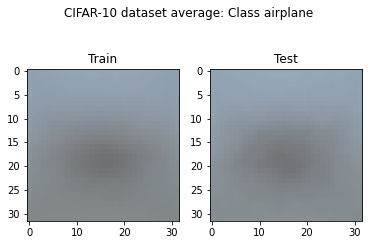

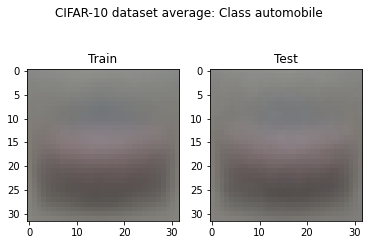

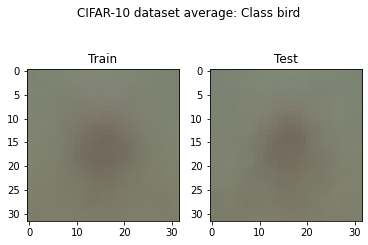

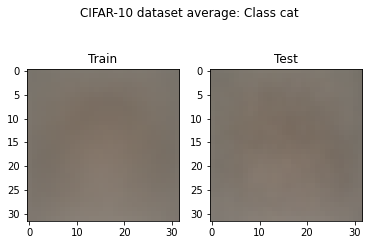

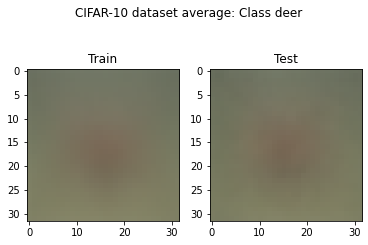

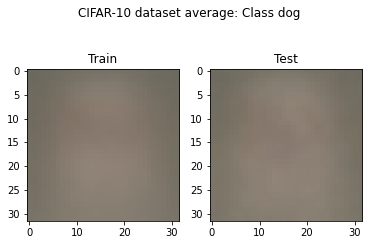

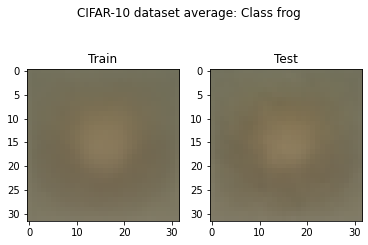

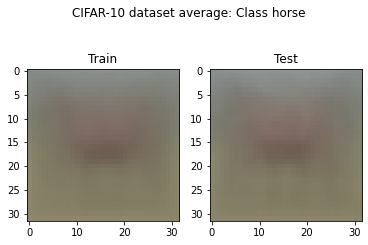

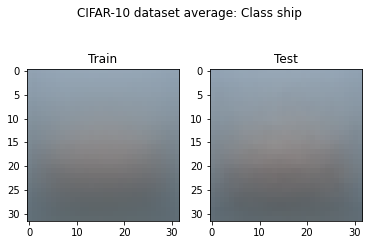

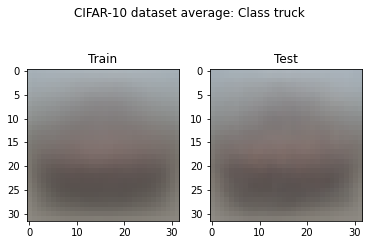

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


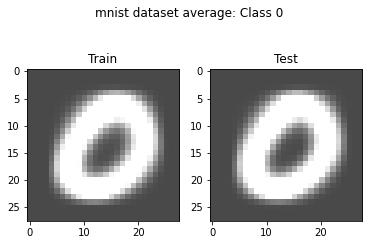

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


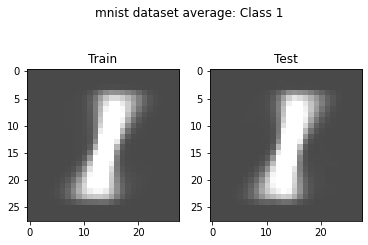

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


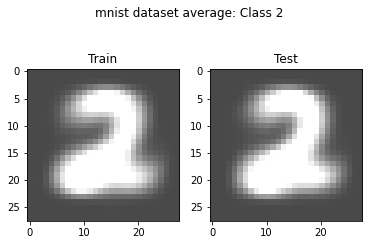

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


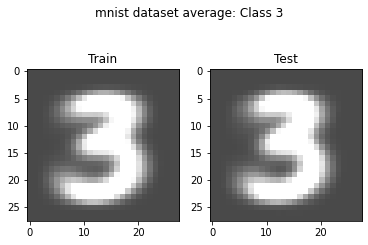

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


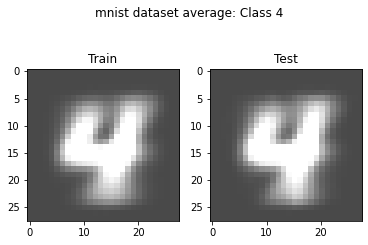

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


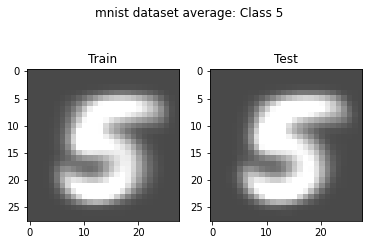

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


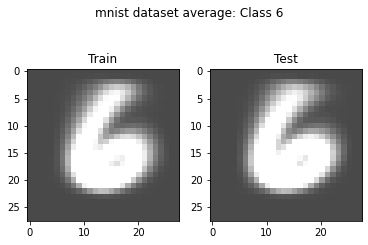

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


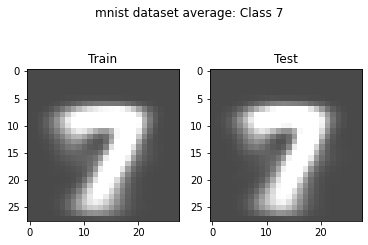

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


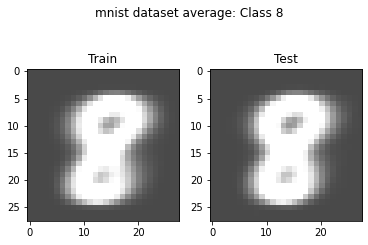

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


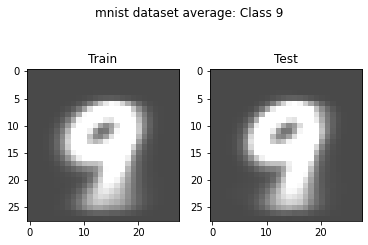

In [29]:
torch.utils.data.DataLoader.num_worker = 0

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [30]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [31]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [32]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    test_loss_curve=[]
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        test_loss_curve.append(F.cross_entropy(output, target, reduction='sum').item())
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss_curve

In [33]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.820877
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.713066
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.532872
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.090674
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.285251
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.008199
Train Epoch: 1 [600/60000 (1%)]	Loss: 1.211453
Train Epoch: 1 [700/60000 (1%)]	Loss: 7.882010
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.000177
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.047078
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.000005
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.009492
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.172348
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.000001
Train Epoch: 1 [1400/60000 (2%)]	Loss: 1.153659
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.099051
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.000048
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.108929
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.000033
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.000001
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.011848
Trai

Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.227824
Train Epoch: 1 [17200/60000 (29%)]	Loss: 0.644307
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.000018
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.000015
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.000000
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000001
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.006088
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.072409
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.000686
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.000252
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.045408
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.000245
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000040
Train Epoch: 1 [18700/60000 (31%)]	Loss: 3.797359
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.000143
Train Epoch: 1 [18900/60000 (32%)]	Loss: 0.000066
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.000026


Train Epoch: 1 [33500/60000 (56%)]	Loss: 0.011988
Train Epoch: 1 [33600/60000 (56%)]	Loss: 0.457262
Train Epoch: 1 [33700/60000 (56%)]	Loss: 1.525398
Train Epoch: 1 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.054550
Train Epoch: 1 [34000/60000 (57%)]	Loss: 4.918221
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.009948
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.010069
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.002892
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.000293
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34700/60000 (58%)]	Loss: 1.345187
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.008086
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.026242
Train Epoch: 1 [35100/60000 (58%)]	Loss: 9.225918
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000000
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.000083
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.000007


Train Epoch: 1 [50100/60000 (84%)]	Loss: 0.000011
Train Epoch: 1 [50200/60000 (84%)]	Loss: 0.014404
Train Epoch: 1 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50400/60000 (84%)]	Loss: 0.001008
Train Epoch: 1 [50500/60000 (84%)]	Loss: 1.723201
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.008527
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.003625
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.008017
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000008
Train Epoch: 1 [51300/60000 (86%)]	Loss: 20.701180
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.000748
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.000005
Train Epoch: 1 [51700/60000 (86%)]	Loss: 0.301180
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.000012

Train Epoch: 2 [7100/60000 (12%)]	Loss: 0.000006
Train Epoch: 2 [7200/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7300/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7400/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000003
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.000017
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000942
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.014365
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8400/60000 (14%)]	Loss: 6.766703
Train Epoch: 2 [8500/60000 (14%)]	Loss: 0.000001
Train Epoch: 2 [8600/60000 (14%)]	Loss: 0.027641
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.294159
Train Epoch: 2 [8800/60000 (15%)]	Loss: 4.375384
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.000002
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9100

Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.035506
Train Epoch: 2 [24300/60000 (40%)]	Loss: 2.614614
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.002182
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.001723
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.097018
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24900/60000 (42%)]	Loss: 8.028258
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.791153
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25700/60000 (43%)]	Loss: 0.000001
Train Epoch: 2 [25800/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25900/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [26000/60000 (43%)]	Loss: 0.000000


Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.000002
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.000009
Train Epoch: 2 [41200/60000 (69%)]	Loss: 10.531554
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.000001
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.074856
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000019
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.276974
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.586556
Train Epoch: 2 [42100/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42200/60000 (70%)]	Loss: 0.701456
Train Epoch: 2 [42300/60000 (70%)]	Loss: 0.002015
Train Epoch: 2 [42400/60000 (71%)]	Loss: 0.000205
Train Epoch: 2 [42500/60000 (71%)]	Loss: 0.000000
Train Epoch: 2 [42600/60000 (71%)]	Loss: 0.000000
Train Epoch: 2 [42700/60000 (71%)]	Loss: 0.015587

Train Epoch: 2 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000008
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.000002
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.510343
Train Epoch: 2 [58000/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58100/60000 (97%)]	Loss: 8.430674
Train Epoch: 2 [58200/60000 (97%)]	Loss: 1.835407
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.000006
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58600/60000 (98%)]	Loss: 0.000003
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.009359
Train Epoch: 2 [58800/60000 (98%)]	Loss: 4.173859
Train Epoch: 2 [58900/60000 (98%)]	Loss: 0.015868
Train Epoch: 2 [59000/60000 (98%)]	Loss: 0.000900
Train Epoch: 2 [59100/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [59200/60000 (99%)]	Loss: 0.000000
Train Epoch: 2 [59300/60000 (99%)]	Loss: 0.000000
Train Epoch: 2 [59400/60000 (99%)]	Loss: 0.005829


Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.000010
Train Epoch: 3 [14500/60000 (24%)]	Loss: 0.000000
Train Epoch: 3 [14600/60000 (24%)]	Loss: 0.053578
Train Epoch: 3 [14700/60000 (24%)]	Loss: 18.539816
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.000077
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.000722
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.000001
Train Epoch: 3 [15500/60000 (26%)]	Loss: 5.831285
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.000009
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.000105
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.001111
Train Epoch: 3 [16100/60000 (27%)]	Loss: 0.953137
Train Epoch: 3 [16200/60000 (27%)]	Loss: 0.000000
Train Epoch: 3 [16300/60000 (27%)]	Loss: 0.000000

Train Epoch: 3 [30900/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31000/60000 (52%)]	Loss: 0.637899
Train Epoch: 3 [31100/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.116724
Train Epoch: 3 [31300/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.265770
Train Epoch: 3 [31500/60000 (52%)]	Loss: 5.419360
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.000349
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000026
Train Epoch: 3 [32100/60000 (54%)]	Loss: 2.143461
Train Epoch: 3 [32200/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32300/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.000060
Train Epoch: 3 [32500/60000 (54%)]	Loss: 17.991505
Train Epoch: 3 [32600/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.000120
Train Epoch: 3 [32800/60000 (55%)]	Loss: 0.000001

Train Epoch: 3 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47400/60000 (79%)]	Loss: 0.000055
Train Epoch: 3 [47500/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47600/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47700/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [47800/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [47900/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.002820
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000039
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48300/60000 (80%)]	Loss: 2.787407
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48500/60000 (81%)]	Loss: 7.237727
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.592283
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.002776
Train Epoch: 3 [48800/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48900/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.000685


Train Epoch: 4 [4100/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4200/60000 (7%)]	Loss: 0.000014
Train Epoch: 4 [4300/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4400/60000 (7%)]	Loss: 0.000001
Train Epoch: 4 [4500/60000 (8%)]	Loss: 0.000445
Train Epoch: 4 [4600/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000261
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5100/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5300/60000 (9%)]	Loss: 9.952708
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000001
Train Epoch: 4 [5500/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5600/60000 (9%)]	Loss: 0.000002
Train Epoch: 4 [5700/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.000089
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.000033
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6100/60000 (10%)]	Lo

Train Epoch: 4 [20700/60000 (34%)]	Loss: 0.004719
Train Epoch: 4 [20800/60000 (35%)]	Loss: 0.000014
Train Epoch: 4 [20900/60000 (35%)]	Loss: 0.001103
Train Epoch: 4 [21000/60000 (35%)]	Loss: 0.005967
Train Epoch: 4 [21100/60000 (35%)]	Loss: 0.019848
Train Epoch: 4 [21200/60000 (35%)]	Loss: 0.223912
Train Epoch: 4 [21300/60000 (36%)]	Loss: 0.000001
Train Epoch: 4 [21400/60000 (36%)]	Loss: 4.666194
Train Epoch: 4 [21500/60000 (36%)]	Loss: 23.922413
Train Epoch: 4 [21600/60000 (36%)]	Loss: 0.723154
Train Epoch: 4 [21700/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000073
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.944457
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.048456
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.000187
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.000076
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.000051

Train Epoch: 4 [37500/60000 (62%)]	Loss: 0.003810
Train Epoch: 4 [37600/60000 (63%)]	Loss: 0.000089
Train Epoch: 4 [37700/60000 (63%)]	Loss: 0.000001
Train Epoch: 4 [37800/60000 (63%)]	Loss: 0.000000
Train Epoch: 4 [37900/60000 (63%)]	Loss: 0.099598
Train Epoch: 4 [38000/60000 (63%)]	Loss: 1.986642
Train Epoch: 4 [38100/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38200/60000 (64%)]	Loss: 0.000134
Train Epoch: 4 [38300/60000 (64%)]	Loss: 0.000040
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38500/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.000035
Train Epoch: 4 [38700/60000 (64%)]	Loss: 0.000248
Train Epoch: 4 [38800/60000 (65%)]	Loss: 3.253071
Train Epoch: 4 [38900/60000 (65%)]	Loss: 7.874114
Train Epoch: 4 [39000/60000 (65%)]	Loss: 0.337691
Train Epoch: 4 [39100/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39300/60000 (66%)]	Loss: 0.000002
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.003804


Train Epoch: 4 [54100/60000 (90%)]	Loss: 0.395903
Train Epoch: 4 [54200/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [54300/60000 (90%)]	Loss: 0.001609
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54500/60000 (91%)]	Loss: 0.000002
Train Epoch: 4 [54600/60000 (91%)]	Loss: 0.000001
Train Epoch: 4 [54700/60000 (91%)]	Loss: 0.005103
Train Epoch: 4 [54800/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54900/60000 (92%)]	Loss: 0.000001
Train Epoch: 4 [55000/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55100/60000 (92%)]	Loss: 0.000006
Train Epoch: 4 [55200/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55300/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.001180
Train Epoch: 4 [55500/60000 (92%)]	Loss: 0.000005
Train Epoch: 4 [55600/60000 (93%)]	Loss: 18.293207
Train Epoch: 4 [55700/60000 (93%)]	Loss: 0.000021
Train Epoch: 4 [55800/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.000079
Train Epoch: 4 [56000/60000 (93%)]	Loss: 26.71930

Train Epoch: 5 [11000/60000 (18%)]	Loss: 0.000123
Train Epoch: 5 [11100/60000 (18%)]	Loss: 0.000000
Train Epoch: 5 [11200/60000 (19%)]	Loss: 0.000005
Train Epoch: 5 [11300/60000 (19%)]	Loss: 0.013567
Train Epoch: 5 [11400/60000 (19%)]	Loss: 0.000100
Train Epoch: 5 [11500/60000 (19%)]	Loss: 0.013612
Train Epoch: 5 [11600/60000 (19%)]	Loss: 0.000000
Train Epoch: 5 [11700/60000 (20%)]	Loss: 0.001073
Train Epoch: 5 [11800/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [11900/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.003311
Train Epoch: 5 [12100/60000 (20%)]	Loss: 2.116924
Train Epoch: 5 [12200/60000 (20%)]	Loss: 0.276493
Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12400/60000 (21%)]	Loss: 0.000001
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.020812


Train Epoch: 5 [27700/60000 (46%)]	Loss: 0.000000
Train Epoch: 5 [27800/60000 (46%)]	Loss: 5.568963
Train Epoch: 5 [27900/60000 (46%)]	Loss: 0.000490
Train Epoch: 5 [28000/60000 (47%)]	Loss: 0.000001
Train Epoch: 5 [28100/60000 (47%)]	Loss: 0.072272
Train Epoch: 5 [28200/60000 (47%)]	Loss: 0.000010
Train Epoch: 5 [28300/60000 (47%)]	Loss: 0.002480
Train Epoch: 5 [28400/60000 (47%)]	Loss: 0.000064
Train Epoch: 5 [28500/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28600/60000 (48%)]	Loss: 0.000138
Train Epoch: 5 [28700/60000 (48%)]	Loss: 0.004655
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28900/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29000/60000 (48%)]	Loss: 0.000001
Train Epoch: 5 [29100/60000 (48%)]	Loss: 0.000003
Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.718065


Train Epoch: 5 [44500/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44600/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44700/60000 (74%)]	Loss: 8.630915
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000007
Train Epoch: 5 [44900/60000 (75%)]	Loss: 0.000005
Train Epoch: 5 [45000/60000 (75%)]	Loss: 2.682617
Train Epoch: 5 [45100/60000 (75%)]	Loss: 0.000000
Train Epoch: 5 [45200/60000 (75%)]	Loss: 0.000008
Train Epoch: 5 [45300/60000 (76%)]	Loss: 0.000004
Train Epoch: 5 [45400/60000 (76%)]	Loss: 4.616770
Train Epoch: 5 [45500/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45600/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45700/60000 (76%)]	Loss: 0.000319
Train Epoch: 5 [45800/60000 (76%)]	Loss: 1.687987
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000001
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000006
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.000000


Train Epoch: 6 [1000/60000 (2%)]	Loss: 0.000600
Train Epoch: 6 [1100/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1200/60000 (2%)]	Loss: 0.095300
Train Epoch: 6 [1300/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1400/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1500/60000 (2%)]	Loss: 0.000000
Train Epoch: 6 [1600/60000 (3%)]	Loss: 0.000012
Train Epoch: 6 [1700/60000 (3%)]	Loss: 0.000172
Train Epoch: 6 [1800/60000 (3%)]	Loss: 0.000003
Train Epoch: 6 [1900/60000 (3%)]	Loss: 0.000001
Train Epoch: 6 [2000/60000 (3%)]	Loss: 0.000000
Train Epoch: 6 [2100/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2200/60000 (4%)]	Loss: 0.000017
Train Epoch: 6 [2300/60000 (4%)]	Loss: 0.181577
Train Epoch: 6 [2400/60000 (4%)]	Loss: 1.274642
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.055800
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.041140
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.827881
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000123
Train Epoch: 6 [3000/60000 (5%)]	Loss: 5

Train Epoch: 6 [18000/60000 (30%)]	Loss: 0.000044
Train Epoch: 6 [18100/60000 (30%)]	Loss: 0.000000
Train Epoch: 6 [18200/60000 (30%)]	Loss: 0.009400
Train Epoch: 6 [18300/60000 (30%)]	Loss: 0.000022
Train Epoch: 6 [18400/60000 (31%)]	Loss: 7.018792
Train Epoch: 6 [18500/60000 (31%)]	Loss: 0.000017
Train Epoch: 6 [18600/60000 (31%)]	Loss: 0.000015
Train Epoch: 6 [18700/60000 (31%)]	Loss: 0.000000
Train Epoch: 6 [18800/60000 (31%)]	Loss: 0.000000
Train Epoch: 6 [18900/60000 (32%)]	Loss: 0.000007
Train Epoch: 6 [19000/60000 (32%)]	Loss: 9.535319
Train Epoch: 6 [19100/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000003
Train Epoch: 6 [19300/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.000003
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.001813
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.000156
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000011
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.000090


Train Epoch: 6 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 6 [34600/60000 (58%)]	Loss: 7.711460
Train Epoch: 6 [34700/60000 (58%)]	Loss: 0.000000
Train Epoch: 6 [34800/60000 (58%)]	Loss: 0.000012
Train Epoch: 6 [34900/60000 (58%)]	Loss: 2.307403
Train Epoch: 6 [35000/60000 (58%)]	Loss: 0.000000
Train Epoch: 6 [35100/60000 (58%)]	Loss: 0.000084
Train Epoch: 6 [35200/60000 (59%)]	Loss: 0.002046
Train Epoch: 6 [35300/60000 (59%)]	Loss: 0.000000
Train Epoch: 6 [35400/60000 (59%)]	Loss: 0.000032
Train Epoch: 6 [35500/60000 (59%)]	Loss: 0.000000
Train Epoch: 6 [35600/60000 (59%)]	Loss: 0.000000
Train Epoch: 6 [35700/60000 (60%)]	Loss: 0.023955
Train Epoch: 6 [35800/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [35900/60000 (60%)]	Loss: 0.000003
Train Epoch: 6 [36000/60000 (60%)]	Loss: 1.255145
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36300/60000 (60%)]	Loss: 0.018635
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.038219


Train Epoch: 6 [51300/60000 (86%)]	Loss: 0.000782
Train Epoch: 6 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51500/60000 (86%)]	Loss: 5.320985
Train Epoch: 6 [51600/60000 (86%)]	Loss: 0.000124
Train Epoch: 6 [51700/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51800/60000 (86%)]	Loss: 0.000021
Train Epoch: 6 [51900/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [52000/60000 (87%)]	Loss: 0.000400
Train Epoch: 6 [52100/60000 (87%)]	Loss: 0.000006
Train Epoch: 6 [52200/60000 (87%)]	Loss: 0.000504
Train Epoch: 6 [52300/60000 (87%)]	Loss: 0.002457
Train Epoch: 6 [52400/60000 (87%)]	Loss: 0.079860
Train Epoch: 6 [52500/60000 (88%)]	Loss: 0.000844
Train Epoch: 6 [52600/60000 (88%)]	Loss: 0.000005
Train Epoch: 6 [52700/60000 (88%)]	Loss: 0.000159
Train Epoch: 6 [52800/60000 (88%)]	Loss: 0.000002
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53000/60000 (88%)]	Loss: 8.296606
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.000084
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.000135


Train Epoch: 7 [8200/60000 (14%)]	Loss: 0.024003
Train Epoch: 7 [8300/60000 (14%)]	Loss: 0.000003
Train Epoch: 7 [8400/60000 (14%)]	Loss: 0.000000
Train Epoch: 7 [8500/60000 (14%)]	Loss: 0.000000
Train Epoch: 7 [8600/60000 (14%)]	Loss: 3.416831
Train Epoch: 7 [8700/60000 (14%)]	Loss: 0.050837
Train Epoch: 7 [8800/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [8900/60000 (15%)]	Loss: 8.205750
Train Epoch: 7 [9000/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [9100/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [9200/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [9300/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9400/60000 (16%)]	Loss: 0.000258
Train Epoch: 7 [9500/60000 (16%)]	Loss: 0.000674
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000690
Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.053751
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.468818
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.000270
Train Epoch: 7 [10

Train Epoch: 7 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25000/60000 (42%)]	Loss: 0.007795
Train Epoch: 7 [25100/60000 (42%)]	Loss: 0.578900
Train Epoch: 7 [25200/60000 (42%)]	Loss: 0.000060
Train Epoch: 7 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25400/60000 (42%)]	Loss: 6.725036
Train Epoch: 7 [25500/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25600/60000 (43%)]	Loss: 12.923423
Train Epoch: 7 [25700/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25800/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25900/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [26000/60000 (43%)]	Loss: 0.000138
Train Epoch: 7 [26100/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26200/60000 (44%)]	Loss: 1.461074
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.000001
Train Epoch: 7 [26400/60000 (44%)]	Loss: 1.333125
Train Epoch: 7 [26500/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000001
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.001447
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.003981

Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.000000
Train Epoch: 7 [41700/60000 (70%)]	Loss: 0.000017
Train Epoch: 7 [41800/60000 (70%)]	Loss: 0.000197
Train Epoch: 7 [41900/60000 (70%)]	Loss: 6.544067
Train Epoch: 7 [42000/60000 (70%)]	Loss: 0.000019
Train Epoch: 7 [42100/60000 (70%)]	Loss: 0.000169
Train Epoch: 7 [42200/60000 (70%)]	Loss: 0.064231
Train Epoch: 7 [42300/60000 (70%)]	Loss: 0.000008
Train Epoch: 7 [42400/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42500/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42600/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42700/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42800/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42900/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43000/60000 (72%)]	Loss: 0.000111
Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.000107
Train Epoch: 7 [43200/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000563


Train Epoch: 7 [58000/60000 (97%)]	Loss: 0.000009
Train Epoch: 7 [58100/60000 (97%)]	Loss: 0.000000
Train Epoch: 7 [58200/60000 (97%)]	Loss: 0.005583
Train Epoch: 7 [58300/60000 (97%)]	Loss: 0.000000
Train Epoch: 7 [58400/60000 (97%)]	Loss: 0.000009
Train Epoch: 7 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58600/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58700/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58900/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [59000/60000 (98%)]	Loss: 0.000001
Train Epoch: 7 [59100/60000 (98%)]	Loss: 0.048421
Train Epoch: 7 [59200/60000 (99%)]	Loss: 2.918860
Train Epoch: 7 [59300/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59400/60000 (99%)]	Loss: 0.471389
Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.005642
Train Epoch: 7 [59600/60000 (99%)]	Loss: 12.362978
Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.022092
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59900/60000 (100%)]	Loss: 0.000

Train Epoch: 8 [14900/60000 (25%)]	Loss: 0.000026
Train Epoch: 8 [15000/60000 (25%)]	Loss: 3.528385
Train Epoch: 8 [15100/60000 (25%)]	Loss: 0.000000
Train Epoch: 8 [15200/60000 (25%)]	Loss: 0.000000
Train Epoch: 8 [15300/60000 (26%)]	Loss: 0.000125
Train Epoch: 8 [15400/60000 (26%)]	Loss: 0.680106
Train Epoch: 8 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15600/60000 (26%)]	Loss: 0.951695
Train Epoch: 8 [15700/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15800/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [15900/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.000013
Train Epoch: 8 [16100/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16200/60000 (27%)]	Loss: 0.000030
Train Epoch: 8 [16300/60000 (27%)]	Loss: 0.002131
Train Epoch: 8 [16400/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.000004
Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.000140
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.000000


Train Epoch: 8 [31500/60000 (52%)]	Loss: 0.106484
Train Epoch: 8 [31600/60000 (53%)]	Loss: 8.914828
Train Epoch: 8 [31700/60000 (53%)]	Loss: 0.000927
Train Epoch: 8 [31800/60000 (53%)]	Loss: 2.351373
Train Epoch: 8 [31900/60000 (53%)]	Loss: 0.000057
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000754
Train Epoch: 8 [32100/60000 (54%)]	Loss: 0.005388
Train Epoch: 8 [32200/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32300/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32400/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32500/60000 (54%)]	Loss: 0.000000
Train Epoch: 8 [32600/60000 (54%)]	Loss: 0.000076
Train Epoch: 8 [32700/60000 (54%)]	Loss: 0.000006
Train Epoch: 8 [32800/60000 (55%)]	Loss: 0.000001
Train Epoch: 8 [32900/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33000/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33100/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.898058
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.000001


Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 8 [48100/60000 (80%)]	Loss: 0.000000
Train Epoch: 8 [48200/60000 (80%)]	Loss: 0.000001
Train Epoch: 8 [48300/60000 (80%)]	Loss: 0.000001
Train Epoch: 8 [48400/60000 (81%)]	Loss: 0.000000
Train Epoch: 8 [48500/60000 (81%)]	Loss: 0.000000
Train Epoch: 8 [48600/60000 (81%)]	Loss: 0.000265
Train Epoch: 8 [48700/60000 (81%)]	Loss: 0.431933
Train Epoch: 8 [48800/60000 (81%)]	Loss: 0.000000
Train Epoch: 8 [48900/60000 (82%)]	Loss: 0.000011
Train Epoch: 8 [49000/60000 (82%)]	Loss: 0.000000
Train Epoch: 8 [49100/60000 (82%)]	Loss: 2.998010
Train Epoch: 8 [49200/60000 (82%)]	Loss: 0.000000
Train Epoch: 8 [49300/60000 (82%)]	Loss: 0.000000
Train Epoch: 8 [49400/60000 (82%)]	Loss: 0.000000
Train Epoch: 8 [49500/60000 (82%)]	Loss: 0.000001
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49700/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49800/60000 (83%)]	Loss: 32.610115
Train Epoch: 8 [49900/60000 (83%)]	Loss: 12.55994

Train Epoch: 9 [4900/60000 (8%)]	Loss: 0.006454
Train Epoch: 9 [5000/60000 (8%)]	Loss: 0.000000
Train Epoch: 9 [5100/60000 (8%)]	Loss: 0.000000
Train Epoch: 9 [5200/60000 (9%)]	Loss: 0.480984
Train Epoch: 9 [5300/60000 (9%)]	Loss: 0.000000
Train Epoch: 9 [5400/60000 (9%)]	Loss: 0.000027
Train Epoch: 9 [5500/60000 (9%)]	Loss: 0.000002
Train Epoch: 9 [5600/60000 (9%)]	Loss: 0.000004
Train Epoch: 9 [5700/60000 (10%)]	Loss: 0.001395
Train Epoch: 9 [5800/60000 (10%)]	Loss: 0.000000
Train Epoch: 9 [5900/60000 (10%)]	Loss: 0.000100
Train Epoch: 9 [6000/60000 (10%)]	Loss: 0.252683
Train Epoch: 9 [6100/60000 (10%)]	Loss: 0.000008
Train Epoch: 9 [6200/60000 (10%)]	Loss: 0.000000
Train Epoch: 9 [6300/60000 (10%)]	Loss: 0.000031
Train Epoch: 9 [6400/60000 (11%)]	Loss: 20.582806
Train Epoch: 9 [6500/60000 (11%)]	Loss: 0.000007
Train Epoch: 9 [6600/60000 (11%)]	Loss: 0.000004
Train Epoch: 9 [6700/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6800/60000 (11%)]	Loss: 0.017184
Train Epoch: 9 [6900/60000 

Train Epoch: 9 [21700/60000 (36%)]	Loss: 0.000000
Train Epoch: 9 [21800/60000 (36%)]	Loss: 0.015060
Train Epoch: 9 [21900/60000 (36%)]	Loss: 0.000000
Train Epoch: 9 [22000/60000 (37%)]	Loss: 0.000000
Train Epoch: 9 [22100/60000 (37%)]	Loss: 0.000000
Train Epoch: 9 [22200/60000 (37%)]	Loss: 0.000009
Train Epoch: 9 [22300/60000 (37%)]	Loss: 2.998766
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.000000
Train Epoch: 9 [22500/60000 (38%)]	Loss: 0.000000
Train Epoch: 9 [22600/60000 (38%)]	Loss: 0.106659
Train Epoch: 9 [22700/60000 (38%)]	Loss: 0.000000
Train Epoch: 9 [22800/60000 (38%)]	Loss: 0.000007
Train Epoch: 9 [22900/60000 (38%)]	Loss: 0.000001
Train Epoch: 9 [23000/60000 (38%)]	Loss: 0.311214
Train Epoch: 9 [23100/60000 (38%)]	Loss: 0.009573
Train Epoch: 9 [23200/60000 (39%)]	Loss: 0.000051
Train Epoch: 9 [23300/60000 (39%)]	Loss: 1.694332
Train Epoch: 9 [23400/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23500/60000 (39%)]	Loss: 0.010482
Train Epoch: 9 [23600/60000 (39%)]	Loss: 0.207399


Train Epoch: 9 [38600/60000 (64%)]	Loss: 0.010719
Train Epoch: 9 [38700/60000 (64%)]	Loss: 0.058827
Train Epoch: 9 [38800/60000 (65%)]	Loss: 0.000000
Train Epoch: 9 [38900/60000 (65%)]	Loss: 0.000009
Train Epoch: 9 [39000/60000 (65%)]	Loss: 0.002423
Train Epoch: 9 [39100/60000 (65%)]	Loss: 2.041593
Train Epoch: 9 [39200/60000 (65%)]	Loss: 0.000000
Train Epoch: 9 [39300/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39400/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39500/60000 (66%)]	Loss: 15.709833
Train Epoch: 9 [39600/60000 (66%)]	Loss: 0.101729
Train Epoch: 9 [39700/60000 (66%)]	Loss: 0.037747
Train Epoch: 9 [39800/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39900/60000 (66%)]	Loss: 5.426614
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40100/60000 (67%)]	Loss: 0.000012
Train Epoch: 9 [40200/60000 (67%)]	Loss: 0.000003
Train Epoch: 9 [40300/60000 (67%)]	Loss: 0.000008
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40500/60000 (68%)]	Loss: 0.000000

Train Epoch: 9 [55400/60000 (92%)]	Loss: 0.000000
Train Epoch: 9 [55500/60000 (92%)]	Loss: 1.082693
Train Epoch: 9 [55600/60000 (93%)]	Loss: 0.000000
Train Epoch: 9 [55700/60000 (93%)]	Loss: 0.000018
Train Epoch: 9 [55800/60000 (93%)]	Loss: 0.001188
Train Epoch: 9 [55900/60000 (93%)]	Loss: 0.000086
Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.000037
Train Epoch: 9 [56100/60000 (94%)]	Loss: 0.004799
Train Epoch: 9 [56200/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56300/60000 (94%)]	Loss: 0.000281
Train Epoch: 9 [56400/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56500/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56600/60000 (94%)]	Loss: 0.000058
Train Epoch: 9 [56700/60000 (94%)]	Loss: 0.000003
Train Epoch: 9 [56800/60000 (95%)]	Loss: 2.856914
Train Epoch: 9 [56900/60000 (95%)]	Loss: 0.000006
Train Epoch: 9 [57000/60000 (95%)]	Loss: 0.000001
Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.000001
Train Epoch: 9 [57200/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.000000


Train Epoch: 10 [12300/60000 (20%)]	Loss: 0.000726
Train Epoch: 10 [12400/60000 (21%)]	Loss: 0.000000
Train Epoch: 10 [12500/60000 (21%)]	Loss: 0.012211
Train Epoch: 10 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 10 [12700/60000 (21%)]	Loss: 0.001543
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000017
Train Epoch: 10 [12900/60000 (22%)]	Loss: 7.171789
Train Epoch: 10 [13000/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13100/60000 (22%)]	Loss: 0.000006
Train Epoch: 10 [13200/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13300/60000 (22%)]	Loss: 0.000004
Train Epoch: 10 [13400/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13500/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13600/60000 (23%)]	Loss: 0.000002
Train Epoch: 10 [13700/60000 (23%)]	Loss: 0.002786
Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13900/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [14000/60000 (23%)]	Loss: 4.989527
Train Epoch: 10 [14100/60000 (24%)]	Loss: 0.004946
Train Epoch: 10 [14200/60000 (2

Train Epoch: 10 [28900/60000 (48%)]	Loss: 0.000500
Train Epoch: 10 [29000/60000 (48%)]	Loss: 0.000007
Train Epoch: 10 [29100/60000 (48%)]	Loss: 0.000514
Train Epoch: 10 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29300/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29400/60000 (49%)]	Loss: 0.030944
Train Epoch: 10 [29500/60000 (49%)]	Loss: 0.000022
Train Epoch: 10 [29600/60000 (49%)]	Loss: 0.000037
Train Epoch: 10 [29700/60000 (50%)]	Loss: 1.875151
Train Epoch: 10 [29800/60000 (50%)]	Loss: 0.000001
Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.431168
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.000137
Train Epoch: 10 [30100/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30200/60000 (50%)]	Loss: 0.000303
Train Epoch: 10 [30300/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.000003
Train Epoch: 10 [30600/60000 (51%)]	Loss: 0.001137
Train Epoch: 10 [30700/60000 (51%)]	Loss: 0.000007
Train Epoch: 10 [30800/60000 (5

Train Epoch: 10 [45500/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45600/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45700/60000 (76%)]	Loss: 0.011387
Train Epoch: 10 [45800/60000 (76%)]	Loss: 0.002851
Train Epoch: 10 [45900/60000 (76%)]	Loss: 0.030636
Train Epoch: 10 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46100/60000 (77%)]	Loss: 3.395973
Train Epoch: 10 [46200/60000 (77%)]	Loss: 0.000007
Train Epoch: 10 [46300/60000 (77%)]	Loss: 3.614428
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46700/60000 (78%)]	Loss: 0.000002
Train Epoch: 10 [46800/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.010044
Train Epoch: 10 [47000/60000 (78%)]	Loss: 0.711643
Train Epoch: 10 [47100/60000 (78%)]	Loss: 0.001648
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47400/60000 (7

[64.56836700439453,
 29.87081527709961,
 22.186893463134766,
 49.33922576904297,
 43.83131790161133,
 96.71083068847656,
 56.48698806762695,
 66.05335235595703,
 53.857460021972656,
 53.323699951171875,
 81.0954360961914,
 47.356014251708984,
 7.146864414215088,
 61.31517028808594,
 60.42240524291992,
 65.00531768798828,
 60.40897750854492,
 90.64877319335938,
 94.2045669555664,
 112.25335693359375,
 78.38409423828125,
 32.182289123535156,
 43.48747634887695,
 70.56981658935547,
 66.0561294555664,
 73.72278594970703,
 68.52758026123047,
 94.27653503417969,
 44.296714782714844,
 40.39853286743164,
 66.95396423339844,
 91.6917724609375,
 73.08982849121094,
 66.57732391357422,
 111.20521545410156,
 114.35720825195312,
 14.573718070983887,
 112.23323059082031,
 50.339263916015625,
 65.64106750488281,
 87.89400482177734,
 78.78289794921875,
 47.08063507080078,
 50.945526123046875,
 48.25115966796875,
 83.01199340820312,
 46.11219787597656,
 16.431583404541016,
 106.52693176269531,
 32.90373

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


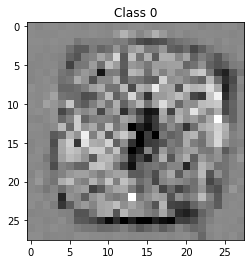

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


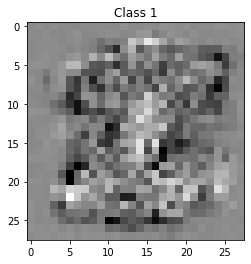

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


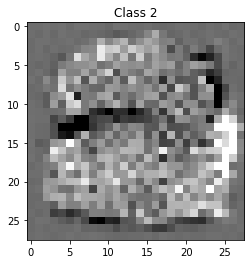

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


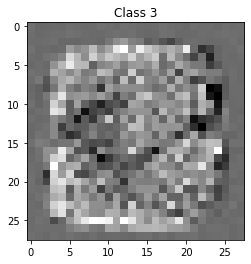

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


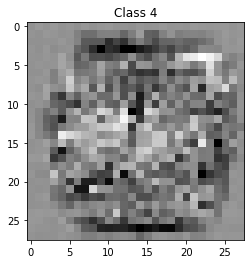

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


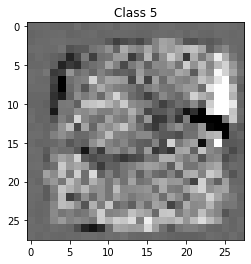

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


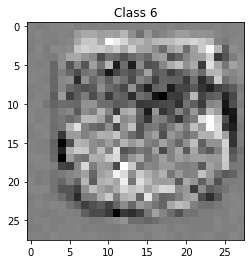

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


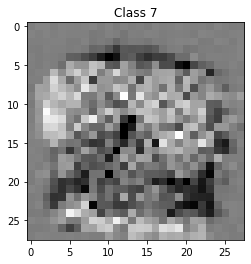

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


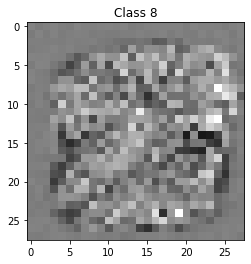

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


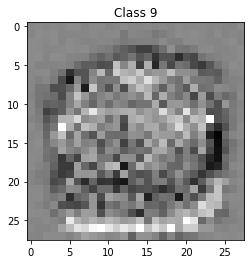

In [34]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp = temp / 2 + 0.5  # un-normalize
        temp_np = temp.numpy()
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [35]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(network.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
        
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [36]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352926
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.275093
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.391980
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.365273
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.217748
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.477791
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.525604
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.599538
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.321627
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.523707

Test set: Average loss: 2.3804, Accuracy: 1247/10000 (12%)



# **Answer (3):**
create needed blocks of code (and results) below

In [37]:
class MultiLayerNet(nn.Module):
    def __init__(self, in_features, nb_classes, nb_hidden_layer,
                 hidden_size, act=nn.ReLU):
        
        super(MultiLayerNet, self).__init__()
        
        self.act = act()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.fcs = nn.ModuleList([])
        self.out = nn.Linear(hidden_size, nb_classes)
                
        self.linear_relu_stack = None
        

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [38]:
lr = 0.01

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(num_inputs, num_outputs, 1, 1000)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    network.fcs.extend(nn.ModuleList([nn.Linear(1000, 1000)]))
    
    network.linear_relu_stack = nn.Sequential(
            network.fc1,
            nn.ReLU(),
            network.fcs[0],
            nn.ReLU(),
            network.out,
        )

    for i in range(1, epochs+1):
        train(i, mnist_train_loader)

    test(mnist_test_loader)
    
    lr *= 10

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318376
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.941588
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.312245
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.140996
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.809081
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.594976
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.451876
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.612212
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.656732
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.325966
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.313987
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.343478
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.558548
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.345254
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.263098
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.352164
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.346576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.296468
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.290370
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.027672
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.017398
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.034099
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.048460
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.016662
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.011761
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.036322
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.016157
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.014648
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.012167
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.038395
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.007517
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.020293
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.011303
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.008209
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.026501
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.026947
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.010027
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.018563
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.032682
Train Epoch:

Train Epoch: 3 [51200/60000 (85%)]	Loss: nan
Train Epoch: 3 [57600/60000 (96%)]	Loss: nan
Train Epoch: 4 [0/60000 (0%)]	Loss: nan
Train Epoch: 4 [6400/60000 (11%)]	Loss: nan
Train Epoch: 4 [12800/60000 (21%)]	Loss: nan
Train Epoch: 4 [19200/60000 (32%)]	Loss: nan
Train Epoch: 4 [25600/60000 (43%)]	Loss: nan
Train Epoch: 4 [32000/60000 (53%)]	Loss: nan
Train Epoch: 4 [38400/60000 (64%)]	Loss: nan
Train Epoch: 4 [44800/60000 (75%)]	Loss: nan
Train Epoch: 4 [51200/60000 (85%)]	Loss: nan
Train Epoch: 4 [57600/60000 (96%)]	Loss: nan
Train Epoch: 5 [0/60000 (0%)]	Loss: nan
Train Epoch: 5 [6400/60000 (11%)]	Loss: nan
Train Epoch: 5 [12800/60000 (21%)]	Loss: nan
Train Epoch: 5 [19200/60000 (32%)]	Loss: nan
Train Epoch: 5 [25600/60000 (43%)]	Loss: nan
Train Epoch: 5 [32000/60000 (53%)]	Loss: nan
Train Epoch: 5 [38400/60000 (64%)]	Loss: nan
Train Epoch: 5 [44800/60000 (75%)]	Loss: nan
Train Epoch: 5 [51200/60000 (85%)]	Loss: nan
Train Epoch: 5 [57600/60000 (96%)]	Loss: nan
Train Epoch: 6 [0/6000

# **Answer (4):**
create needed blocks of code (and results) below

In [39]:
dataset = 'cifar10'
lr = 0.01

In [85]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, (5, 5), (2, 2)) # with tanh
        self.conv2 = nn.Conv2d(16, 64, (3, 3), (1, 1)) # with tanh
        self.conv3 = nn.Conv2d(64, 64, (3, 3), (1, 1)) # with tanh
        self.fc1 = nn.Linear(1024 * 64, 64)
        self.first_linear = nn.Linear(64, 64)
        self.second_linear = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv3(x)) 
        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x)
        x = self.fc1(x)
        # Pass data through first_linear
        x = self.first_linear(x)
        x = F.relu(x)
        x = self.second_linear(x)
        return x

In [87]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def conv_layers(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))
        out = F.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        out = F.relu(self.bn_conv3(self.conv3(out)))
        out = F.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        return out

    def dense_layers(self, x):
        out = F.relu(self.bn_dense1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn_dense2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(-1, 256 * 8 * 8)
        out = self.dense_layers(out)
        return out

In [ ]:
epochs = 20 
network = MyNet()
optimizer = optim.SGD(network.parameters(), lr=lr)

for i in range(1, epochs+1):
    train(i, cifar_train_loader)
    
res = test(cifar_ctest_loader)
# for i in range(epochs-1):
#     plt.plot((i, res[i]), (i + 1, res[i + 1]))
    
# plt.show()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.564336
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.711374
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.613503
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.375968
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.323472
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.262203
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.203945
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.241791
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.490434
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.333858
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.154521
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.106330
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.165414
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.299138
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.253107
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.166816
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.965942
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.020768
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.101919
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.029542
Train Epoch: 3 [25

In [86]:
epochs = 20 
network = ConvNet()
optimizer = optim.SGD(network.parameters(), lr=lr)

for i in range(1, epochs+1):
    train(i, cifar_train_loader)
    
res = test(cifar_test_loader)
# for i in range(epochs-1):
#     plt.plot((i, res[i]), (i + 1, res[i + 1]))
    
# plt.show()

RuntimeError: Given groups=1, weight of size [16, 1, 5, 5], expected input[64, 3, 32, 32] to have 1 channels, but got 3 channels instead